# Raster Data in Python

In [30]:
import os

import earthpy as et
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr

In [2]:
et.data.get_data('colorado-flood')

'/Users/elsa/earth-analytics/data/colorado-flood/.'

In [3]:
os.chdir(os.path.join(
    et.io.HOME, 'earth-analytics', 'data', 'colorado-flood'))

In [4]:
%%bash
find .

.
./precipitation
./precipitation/PRECIP_HLY_documentation.pdf
./precipitation/805333-precip-daily-1948-2013.csv
./precipitation/805325-precip-dailysum-2003-2013.csv
./precipitation/805325-precip-daily-2003-2013.csv
./precipitation/precip-boulder-aug-oct-2013.csv
./discharge
./discharge/README_dischargeMetadata.rtf
./discharge/06730200-discharge-daily-1986-2013.csv
./discharge/06730200-discharge-daily-1986-2013.txt
./spatial
./spatial/boulder-leehill-rd
./spatial/boulder-leehill-rd/clip-extent.qpj
./spatial/boulder-leehill-rd/clip-extent.prj
./spatial/boulder-leehill-rd/README.md
./spatial/boulder-leehill-rd/clip-extent.dbf
./spatial/boulder-leehill-rd/post-flood
./spatial/boulder-leehill-rd/post-flood/lidar
./spatial/boulder-leehill-rd/post-flood/lidar/post_DTM_hill.tif
./spatial/boulder-leehill-rd/post-flood/lidar/post_DTM.tif
./spatial/boulder-leehill-rd/post-flood/lidar/post_DSM.tif
./spatial/boulder-leehill-rd/post-flood/lidar/post_DSM_hill.tif
./spatial/boulder-leehill-rd/pre-flo

In [5]:
leehill_dir = os.path.join('spatial', 'boulder-leehill-rd')

pre_post_str = ['pre', 'post']
dtm_dsm_str = ['DTM', 'DSM']

lidar_pths = {}
for timing_str in pre_post_str:
    for type_str in dtm_dsm_str:
        pth = (os.path.join(leehill_dir, '{}-flood', 'lidar', '{}_{}.tif')
         .format(timing_str, timing_str, type_str))
        lidar_pths['{}_{}'.format(timing_str, type_str)] = pth
lidar_pths

{'pre_DTM': 'spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif',
 'pre_DSM': 'spatial/boulder-leehill-rd/pre-flood/lidar/pre_DSM.tif',
 'post_DTM': 'spatial/boulder-leehill-rd/post-flood/lidar/post_DTM.tif',
 'post_DSM': 'spatial/boulder-leehill-rd/post-flood/lidar/post_DSM.tif'}

In [8]:
pre_dtm = rxr.open_rasterio(lidar_pths['pre_DTM']).squeeze()
pre_dsm = rxr.open_rasterio(lidar_pths['pre_DSM']).squeeze()
pre_dsm - pre_dtm

<xarray.DataArray (y: 2000, x: 4000)>
array([[4.0564819e+31, 4.0564819e+31, 4.0564819e+31, ..., 0.0000000e+00,
        1.7004395e-01, 9.6008301e-01],
       [4.0564819e+31, 4.0564819e+31, 4.0564819e+31, ..., 0.0000000e+00,
        9.0087891e-02, 1.6400146e+00],
       [4.0564819e+31, 4.0564819e+31, 4.0564819e+31, ..., 0.0000000e+00,
        0.0000000e+00, 7.9956055e-02],
       ...,
       [4.0564819e+31, 4.0564819e+31, 4.0564819e+31, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.0564819e+31, 4.0564819e+31, 4.0564819e+31, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.0564819e+31, 4.0564819e+31, 4.0564819e+31, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int64 0

In [19]:
pre_dtm.rio.crs

CRS.from_epsg(32613)

In [13]:
clip_pth = os.path.join(leehill_dir, 'clip-extent.shp')
clip_gdf = gpd.read_file(clip_pth)
clip_gdf

,id,geometry
0,1,"POLYGON ((472510.465 4436000.000, 476009.764 4..."


In [21]:
clip_gdf.crs, lidar_das['pre_DSM'].rio.crs

(<Projected CRS: EPSG:32613>
 Name: WGS 84 / UTM zone 13N
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: Between 108°W and 102°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Northwest Territories (NWT); Nunavut; Saskatchewan. Mexico. United States (USA).
 - bounds: (-108.0, 0.0, -102.0, 84.0)
 Coordinate Operation:
 - name: UTM zone 13N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 CRS.from_epsg(32613))

In [25]:
def open_and_clip(geotiff_pth, clip_gdf):
    """
    Opens and clips a GeoTIFF file.
    
    Opens a GeoTIFF file while masking NA values, squeezes to get rid
    of extra dimensions, and clips the raster using a GeoDataFrame.
    
    Parameters
    ----------
    geotiff_pth : str 
        Path to the GeoTIFF file to open.
    
    clip_gdf : geopandas.GeoDataFrame
        GeoDataFrame defining the area of interest.
    
    Returns
    -------
    xarray.DataArray
        The clipped data.
    """
    clipped_da = (
        # Open GeoTIFF
        rxr.open_rasterio(geotiff_pth, masked=True)
        # Get rid of extra dimension
        .squeeze()
        # Clip to area of interest
        .rio.clip(clip_gdf.geometry, crs=clip_gdf.crs))
    
    return clipped_da

open_and_clip

Help on function open_and_clip in module __main__:

open_and_clip(geotiff_pth, clip_gdf)
    Opens and clips a GeoTIFF file.
    
    Opens a GeoTIFF file while masking NA values, squeezes to get rid
    of extra dimensions, and clips the raster using a GeoDataFrame.
    
    Parameters
    ----------
    geotiff_pth : str 
        Path to the GeoTIFF file to open.
    
    clip_gdf : geopandas.GeoDataFrame
        GeoDataFrame defining the area of interest.
    
    Returns
    -------
    xarray.DataArray
        The clipped data.



In [27]:
lidar_das = {}
for tif_key in lidar_pths.keys():
    lidar_das[tif_key] = open_and_clip(lidar_pths[tif_key], clip_gdf)

lidar_das

{'pre_DTM': <xarray.DataArray (y: 2000, x: 3490)>
 array([[1982.7899, 1982.5   , 1982.19  , ..., 1695.63  , 1695.4199,
         1695.4299],
        [1983.2799, 1983.14  , 1982.7999, ..., 1695.6   , 1695.5399,
         1695.36  ],
        [1984.0499, 1983.97  , 1983.64  , ..., 1695.38  , 1695.44  ,
         1695.37  ],
        ...,
        [1957.32  , 1957.72  , 1958.13  , ..., 1681.45  , 1681.39  ,
         1681.25  ],
        [1957.6499, 1958.2   , 1958.58  , ..., 1681.72  , 1681.57  ,
         1681.5599],
        [1957.97  , 1958.5199, 1959.08  , ..., 1681.89  , 1681.8099,
         1681.74  ]], dtype=float32)
 Coordinates:
   * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
   * x            (x) float64 4.725e+05 4.725e+05 4.725e+05 ... 4.76e+05 4.76e+05
     band         int64 1
     spatial_ref  int64 0
 Attributes:
     scale_factor:  1.0
     add_offset:    0.0,
 'pre_DSM': <xarray.DataArray (y: 2000, x: 3490)>
 array([[1986.51  , 1989.5499, 1989.59  , ..., 

# Canopy Height Model

CHM = DSM - DTM

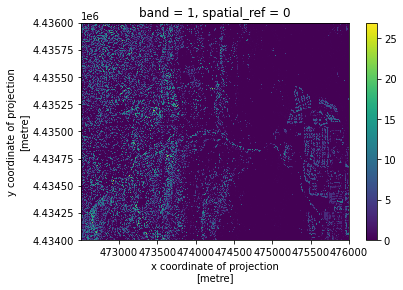

In [22]:
pre_chm = lidar_das['pre_DSM'] - lidar_das['pre_DTM']
pre_chm.plot()

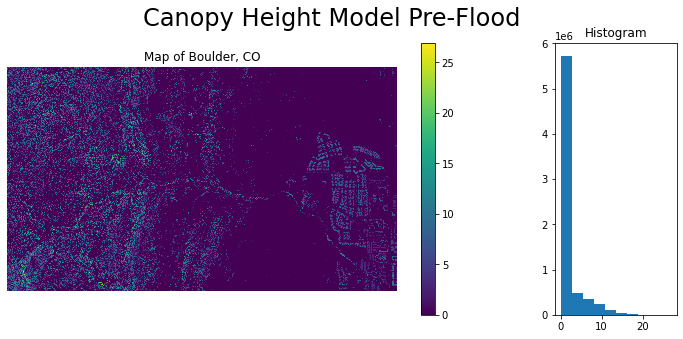

In [50]:
fig, (ax_l, ax_r) = plt.subplots(
    1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [4, 1]})

pre_chm.plot.imshow(ax=ax_l)
ax_l.axes.set_aspect('equal')
ax_l.set_axis_off()
ax_l.set_title('Map of Boulder, CO')

pre_chm.plot.hist()

fig.suptitle('Canopy Height Model Pre-Flood', fontsize=24)
plt.show()